# 1. Basic Analysis of the Data
## 1.1 Data Description

In [1]:
import pandas as pd
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')
print(df.describe())

        Attention          MW      NumFix    AvgFixDur    NumBlink  \
count  960.000000  960.000000  960.000000   960.000000  960.000000   
mean     0.572917    0.427083   58.562500   294.337240   14.836458   
std      0.494912    0.494912   20.009129    97.181563    9.339240   
min      0.000000    0.000000    0.000000     0.000000    0.000000   
25%      0.000000    0.000000   51.000000   240.193713    8.000000   
50%      1.000000    0.000000   63.000000   284.095713   13.000000   
75%      1.000000    1.000000   72.000000   342.726950   20.000000   
max      1.000000    1.000000   95.000000  1083.333333   47.000000   

        AvgBlinkDur   AvgPupDia   VarPupDia  OffStimFram   AvgSacAmp  \
count    960.000000  957.000000  957.000000   960.000000  960.000000   
mean     489.400072    3.625744    0.184662    29.368750    5.903661   
std     1881.966131    0.612144    0.154084    47.123642    1.718801   
min        0.000000    1.736582    0.000000     0.000000    0.000000   
25%      

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')
df['MW'] = df['Attention'].apply(lambda x: 1 if x == 0 else 0)

# Calculate the percentage of Attention==0 for each Stimuli
mw_percentage = df.groupby('Stimuli')['MW'].apply(lambda x: (x == 1).mean() ).reset_index()

# Sort the data for better visualization
mw_percentage = mw_percentage.sort_values(by='MW', ascending=False)
# Plot the bar plot
mean_attention_0 = mw_percentage['MW'].mean()
std_attention_0 = mw_percentage['MW'].std()

print(mw_percentage, sep='\n')
print(f"Avg: {mean_attention_0}, Std: {std_attention_0}")

        Stimuli     MW
9       Italy_4  0.550
22    Vietnam_1  0.525
2      France_1  0.500
5    HongKong_3  0.500
18  Singapore_1  0.475
16     Russia_1  0.475
0      Brazil_1  0.450
17     Russia_3  0.450
11     London_3  0.450
12     Mexico_1  0.450
8       Italy_1  0.450
3      France_3  0.450
7       India_3  0.425
10     London_1  0.400
1      Brazil_3  0.400
13     Mexico_3  0.400
14        NYC_1  0.400
15        NYC_4  0.375
20     Sweden_2  0.375
21     Sweden_4  0.375
23    Vietnam_2  0.375
19  Singapore_3  0.350
6       India_1  0.325
4    HongKong_1  0.325
Avg: 0.4270833333333333, Std: 0.06030568267019983


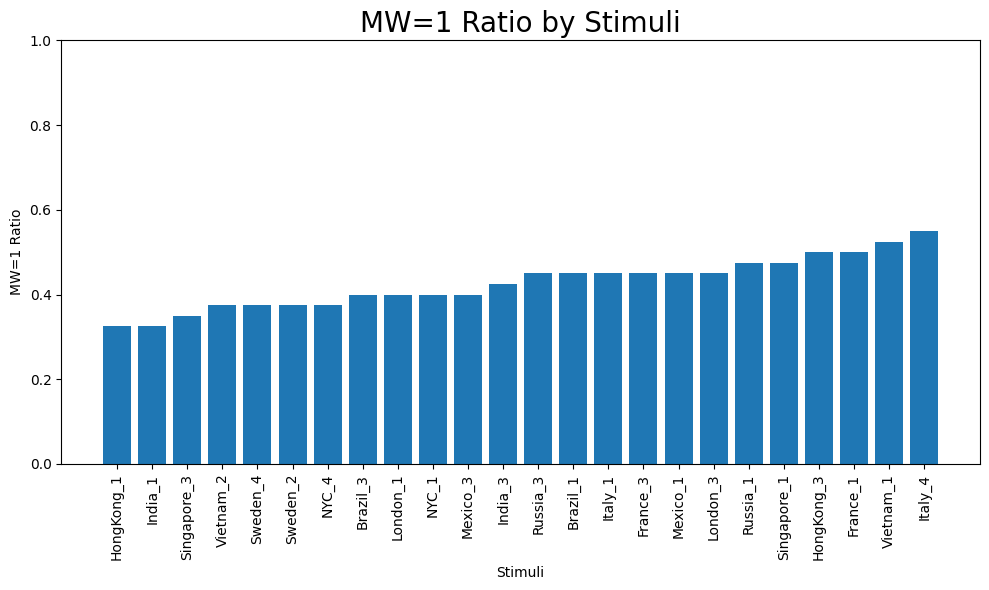

        Stimuli     MW
4    HongKong_1  0.325
6       India_1  0.325
19  Singapore_3  0.350
23    Vietnam_2  0.375
21     Sweden_4  0.375
20     Sweden_2  0.375
15        NYC_4  0.375
1      Brazil_3  0.400
10     London_1  0.400
14        NYC_1  0.400
13     Mexico_3  0.400
7       India_3  0.425
17     Russia_3  0.450
0      Brazil_1  0.450
8       Italy_1  0.450
3      France_3  0.450
12     Mexico_1  0.450
11     London_3  0.450
16     Russia_1  0.475
18  Singapore_1  0.475
5    HongKong_3  0.500
2      France_1  0.500
22    Vietnam_1  0.525
9       Italy_4  0.550
Avg: 0.4270833333333333, Std: 0.06030568267019983


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')

# Create the MW column
df['MW'] = df['Attention'].apply(lambda x: 1 if x == 0 else 0)

# Calculate the percentage of Attention==0 for each Stimuli
mw_percentage = df.groupby('Stimuli')['MW'].apply(lambda x: (x == 1).mean()).reset_index()

# Sort the data for better visualization
mw_percentage = mw_percentage.sort_values(by='MW', ascending=True)

# Calculate mean and standard deviation
mean_attention_0 = mw_percentage['MW'].mean()
std_attention_0 = mw_percentage['MW'].std()

# Plot the bar plot with y-axis from 0 to 1
plt.figure(figsize=(10, 6))
plt.bar(mw_percentage['Stimuli'], mw_percentage['MW'])
plt.xlabel('Stimuli')
plt.ylabel('MW=1 Ratio')
plt.title('MW=1 Ratio by Stimuli', fontsize=20)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the results
print(mw_percentage)
print(f"Avg: {mean_attention_0}, Std: {std_attention_0}")


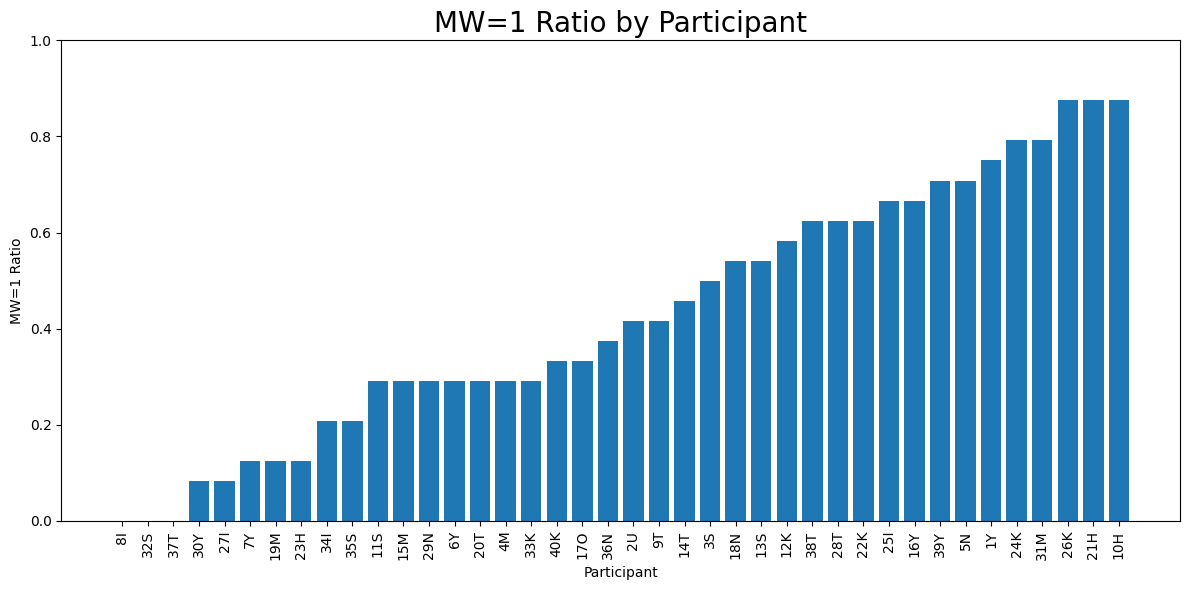

8I     0.000000
32S    0.000000
37T    0.000000
30Y    0.083333
27I    0.083333
7Y     0.125000
19M    0.125000
23H    0.125000
34I    0.208333
35S    0.208333
11S    0.291667
15M    0.291667
29N    0.291667
6Y     0.291667
20T    0.291667
4M     0.291667
33K    0.291667
40K    0.333333
17O    0.333333
36N    0.375000
2U     0.416667
9T     0.416667
14T    0.458333
3S     0.500000
18N    0.541667
13S    0.541667
12K    0.583333
38T    0.625000
28T    0.625000
22K    0.625000
25I    0.666667
16Y    0.666667
39Y    0.708333
5N     0.708333
1Y     0.750000
24K    0.791667
31M    0.791667
26K    0.875000
21H    0.875000
10H    0.875000
dtype: float64
Avg: 0.42708333333333337, Std: 0.2641558478735838, Max: 0.875, Min: 0.0


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')

# Calculate MW column
df['MW'] = df['Attention'].apply(lambda x: 1 if x == 0 else 0)

# Count the number of times each participant had MW=1
mw_counts = df[df['MW'] == 1]['Participant'].value_counts()

# Include all participants, even those with 0 MW counts
all_participants = df['Participant'].unique()
mw_counts_full = pd.Series(0, index=all_participants)
mw_counts_full.update(mw_counts)

# Count total trials for each participant
total_trials = df['Participant'].value_counts()

# Convert MW counts to percentage
mw_percentage = (mw_counts_full / total_trials)

# Sort the data in ascending order
mw_percentage = mw_percentage.sort_values(ascending=True)

# Calculate statistics
mw_avg_full = mw_percentage.mean()
mw_sd_full = mw_percentage.std()
mw_max_full = mw_percentage.max()
mw_min_full = mw_percentage.min()

# Visualize the results with default color and in ascending order
plt.figure(figsize=(12, 6))
plt.bar(mw_percentage.index, mw_percentage.values)
plt.xlabel('Participant')
plt.ylabel('MW=1 Ratio')
plt.title('MW=1 Ratio by Participant', fontsize=20)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the results
print(mw_percentage, sep='\n')
print(f"Avg: {mw_avg_full}, Std: {mw_sd_full}, Max: {mw_max_full}, Min: {mw_min_full}")

**画像によって極端な差があるかどうか確認**

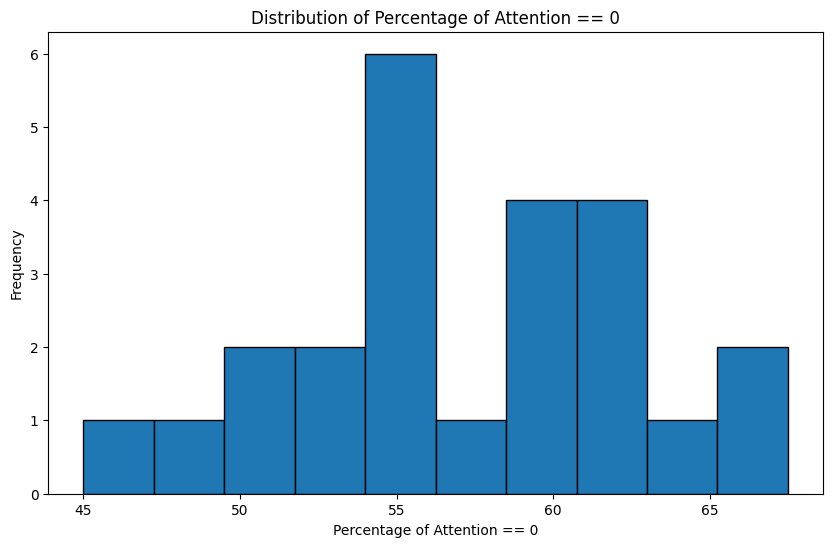

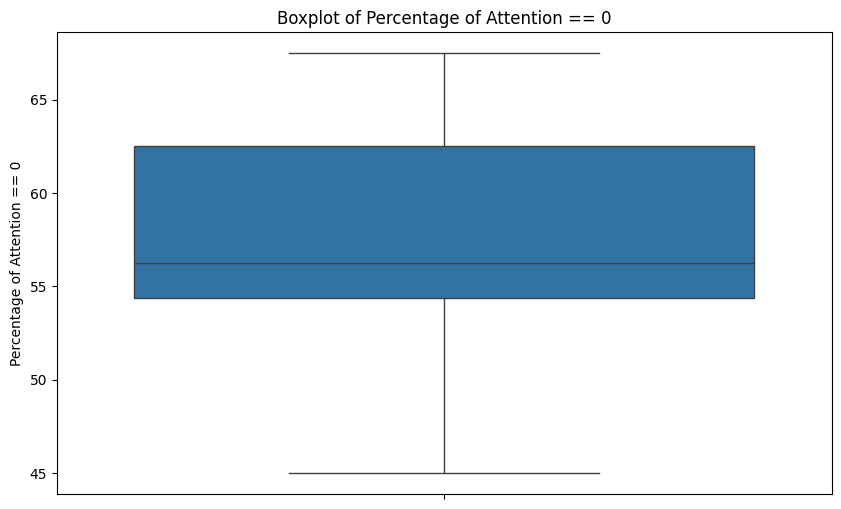

In [18]:
# 1. 分布の確認
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')

# Calculate the percentage of Attention==0 for each Stimuli
attention_percentage = df.groupby('Stimuli')['Attention'].apply(lambda x: (x == 1).mean() * 100).reset_index()

# Sort the data for better visualization
attention_percentage_sorted = attention_percentage.sort_values(by='Attention', ascending=False)
# ヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(attention_percentage_sorted['Attention'], bins=10, edgecolor='black')
plt.xlabel('Percentage of Attention == 0')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of Attention == 0')
plt.show()

# 箱ひげ図
plt.figure(figsize=(10, 6))
sns.boxplot(y=attention_percentage_sorted['Attention'])
plt.ylabel('Percentage of Attention == 0')
plt.title('Boxplot of Percentage of Attention == 0')
plt.show()


## 1.2 Proportion of MW Distribution Among Participants

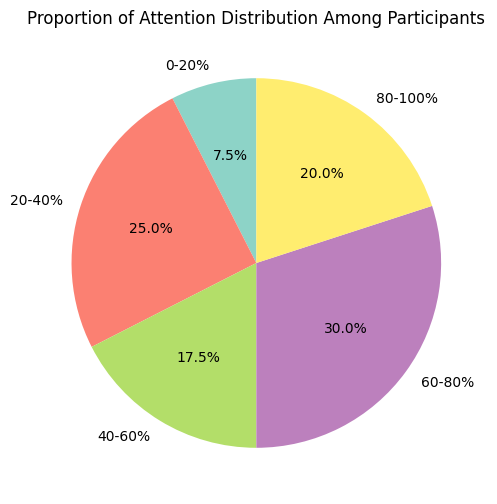

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')

# Calculate the proportion of attention == 1 for each participant
attention_proportion = df.groupby('Participant')['Attention'].mean()

# Define bins for the categories
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"]

# Categorize the proportions into the bins
categories = pd.cut(attention_proportion, bins, labels=labels, include_lowest=True, ordered=True)

# Count the number of participants in each bin
category_counts = categories.value_counts(sort=False)
category_counts_normalized = category_counts / category_counts.sum()

# Plotting
plt.figure(figsize=(10, 6))
category_counts_normalized.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap="Set3", labels=labels)
plt.ylabel('')  # Remove the y-label as it is unnecessary for pie charts
plt.title('Proportion of Attention Distribution Among Participants')
plt.show()


# 2. Identify the best window size using the random forest model

- Cross-validation: Instead of a single train-test split for each iteration, consider using cross-validation. This will provide a more robust measure of model performance as it evaluates the model on multiple train-test splits. You can use cross_val_score for this, but note that it requires splitting the data such that each participant's data is entirely in either the training or the testing set, which might require custom splitting strategies.

- Feature Importance and Selection: Depending on the results and the importance of different features, you might consider feature selection or engineering to improve model performance. RandomForest provides feature importance scores that can help you understand which features are most influential in making predictions.

- Parameter Tuning: You're using the default parameters of RandomForestClassifier. Consider tuning the hyperparameters, like n_estimators, max_depth, etc., using techniques such as grid search or random search to potentially improve model accuracy.

- Validation Strategy: The approach to split data by participants is excellent for ensuring that the model generalizes well over different individuals. However, make sure that your way of splitting truly reflects the independent data distributions you expect to encounter in practice.

- Error Analysis: After determining the best window size, it might be useful to perform an error analysis to see where the model performs poorly. This could provide insights into further improvements in feature engineering or model choice.

- Model Complexity: Evaluate if RandomForest is the best choice or if other models (e.g., SVM, logistic regression, or even neural networks) might yield better results for your specific type of data and problem.

**Cross Validation Implementation:**

**Add a blacklist to filter out the participants with missing data.**

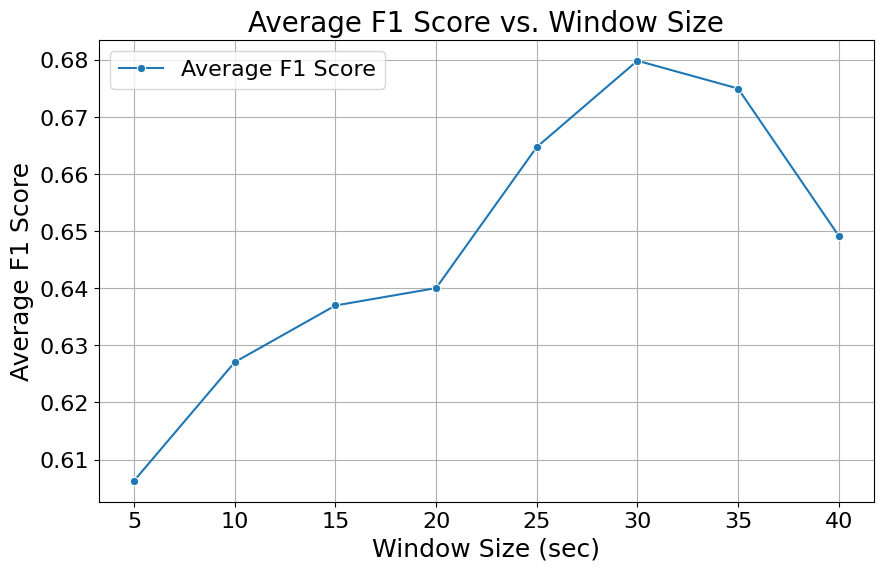

Window size: 5 sec, Average F1 score: 0.606
Window size: 10 sec, Average F1 score: 0.627
Window size: 15 sec, Average F1 score: 0.637
Window size: 20 sec, Average F1 score: 0.640
Window size: 25 sec, Average F1 score: 0.665
Window size: 30 sec, Average F1 score: 0.680
Window size: 35 sec, Average F1 score: 0.675
Window size: 40 sec, Average F1 score: 0.649
Best window size (F1 score): 30 sec with average F1 score: 0.680


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Load CSV files into DataFrames
window_sizes = [5 * i for i in range(1, 9)]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]

# Function to prepare data by participant, excluding blacklist
def prepare_data(df):
    df_filtered = df[~df['Participant'].isin(blacklist)]
    X = df_filtered[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp']]
    y = df_filtered['Attention']
    groups = df_filtered['Participant']
    return X, y, groups

# Number of iterations and random states
iterations = 10
random_states = range(iterations)

# Loop through each DataFrame and random states
results = {w: {'f1_score': []} for w in window_sizes}
for w, df in zip(window_sizes, dataframes):
    X, y, groups = prepare_data(df)
    # Define the cross-validation strategy
    gkf = GroupKFold(n_splits=5)
    
    # Collect cross-validation scores for each random state
    for random_state in random_states:
        clf = RandomForestClassifier(random_state=random_state)
        f1_scorer = make_scorer(f1_score)
        f1_scores = cross_val_score(clf, X, y, groups=groups, cv=gkf, scoring=f1_scorer)
        results[w]['f1_score'].extend(f1_scores)

# Calculate average F1 score for each window size
average_results = {w: {'average_f1_score': np.mean(scores['f1_score'])} for w, scores in results.items()}

# Convert average_results to a DataFrame for plotting
average_results_df = pd.DataFrame.from_dict(average_results, orient='index').reset_index()
average_results_df.columns = ['window_size', 'average_f1_score']

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='window_size', y='average_f1_score', data=average_results_df, marker='o', label='Average F1 Score')

# Adjust font sizes
plt.xlabel('Window Size (sec)', fontsize=18)
plt.ylabel('Average F1 Score', fontsize=18)
plt.title('Average F1 Score vs. Window Size', fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Print results
for w, metrics in average_results.items():
    print(f"Window size: {w} sec, Average F1 score: {metrics['average_f1_score']:.3f}")

# Find the best window size based on F1 score
best_window_f1 = max(average_results, key=lambda w: average_results[w]['average_f1_score'])
print(f"Best window size (F1 score): {best_window_f1} sec with average F1 score: {average_results[best_window_f1]['average_f1_score']:.3f}")


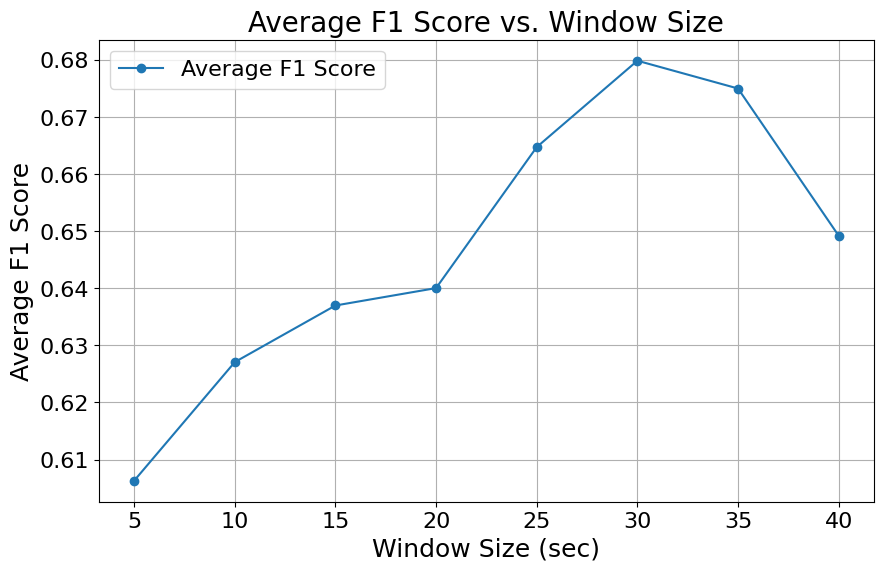

Window size: 5 sec, Average F1 score: 0.606
Window size: 10 sec, Average F1 score: 0.627
Window size: 15 sec, Average F1 score: 0.637
Window size: 20 sec, Average F1 score: 0.640
Window size: 25 sec, Average F1 score: 0.665
Window size: 30 sec, Average F1 score: 0.680
Window size: 35 sec, Average F1 score: 0.675
Window size: 40 sec, Average F1 score: 0.649
Best window size (F1 score): 30 sec with average F1 score: 0.680


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Load CSV files into DataFrames
window_sizes = [5 * i for i in range(1, 9)]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]

# Function to prepare data by participant, excluding blacklist
def prepare_data(df):
    df_filtered = df[~df['Participant'].isin(blacklist)]
    X = df_filtered[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp']]
    y = df_filtered['Attention']
    groups = df_filtered['Participant']
    return X, y, groups

# Number of iterations and random states
iterations = 10
random_states = range(iterations)

# Loop through each DataFrame and random states
results = {w: {'f1_score': []} for w in window_sizes}
for w, df in zip(window_sizes, dataframes):
    X, y, groups = prepare_data(df)
    # Define the cross-validation strategy
    gkf = GroupKFold(n_splits=5)
    
    # Collect cross-validation scores for each random state
    for random_state in random_states:
        clf = RandomForestClassifier(random_state=random_state)
        f1_scorer = make_scorer(f1_score)
        f1_scores = cross_val_score(clf, X, y, groups=groups, cv=gkf, scoring=f1_scorer)
        results[w]['f1_score'].extend(f1_scores)

# Calculate average F1 score for each window size
average_results = {w: {'average_f1_score': np.mean(scores['f1_score'])} for w, scores in results.items()}

# Convert average_results to a DataFrame for plotting
average_results_df = pd.DataFrame.from_dict(average_results, orient='index').reset_index()
average_results_df.columns = ['window_size', 'average_f1_score']

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(average_results_df['window_size'], average_results_df['average_f1_score'], marker='o', label='Average F1 Score')

# Adjust font sizes
plt.xlabel('Window Size (sec)', fontsize=18)
plt.ylabel('Average F1 Score', fontsize=18)
plt.title('Average F1 Score vs. Window Size', fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Print results
for w, metrics in average_results.items():
    print(f"Window size: {w} sec, Average F1 score: {metrics['average_f1_score']:.3f}")

# Find the best window size based on F1 score
best_window_f1 = max(average_results, key=lambda w: average_results[w]['average_f1_score'])
print(f"Best window size (F1 score): {best_window_f1} sec with average F1 score: {average_results[best_window_f1]['average_f1_score']:.3f}")


**Plot the confusion matrix, ROC curve, and AUC**

**Test RF performance after fixation simplification**

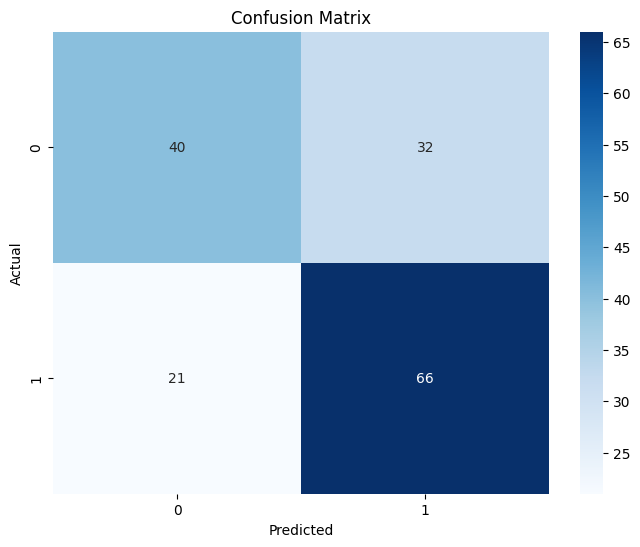

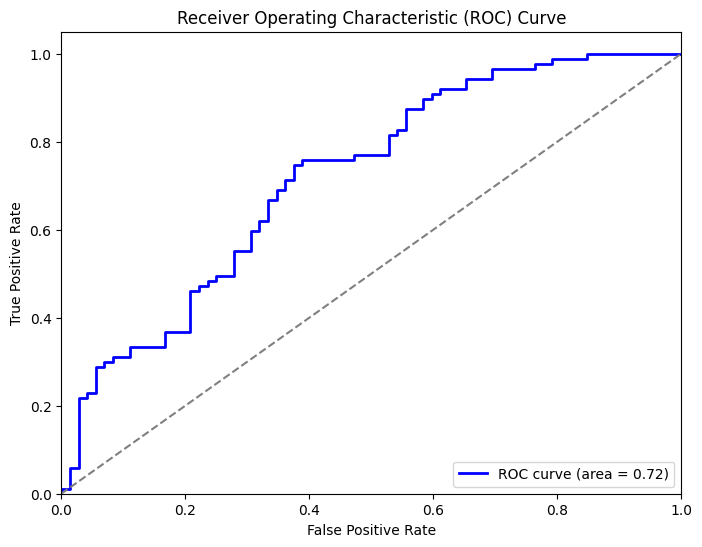

Accuracy: 0.667
F1 score: 0.714
Precision: 0.673
Recall: 0.759
Feature Importances:
NumFix: 0.0689
AvgBlinkDur: 0.0643
CoveredArea: 0.0610
VarPupDia: 0.0607
AvgPupDia: 0.0549
AvgFixDisp: 0.0545
AvgFixDur: 0.0511
AvgFixDisp_Sim: 0.0509
NumFix_Sim: 0.0436
rec: 0.0389
AvgSacAmp: 0.0384
relent: 0.0369
nrec: 0.0362
meanline: 0.0355
AvgFixDur_Sim: 0.0342
revdet: 0.0340
maxline: 0.0337
tt: 0.0314
det: 0.0308
NumBlink: 0.0307
lam: 0.0306
corm: 0.0288
OffStimFram: 0.0269
ent: 0.0231


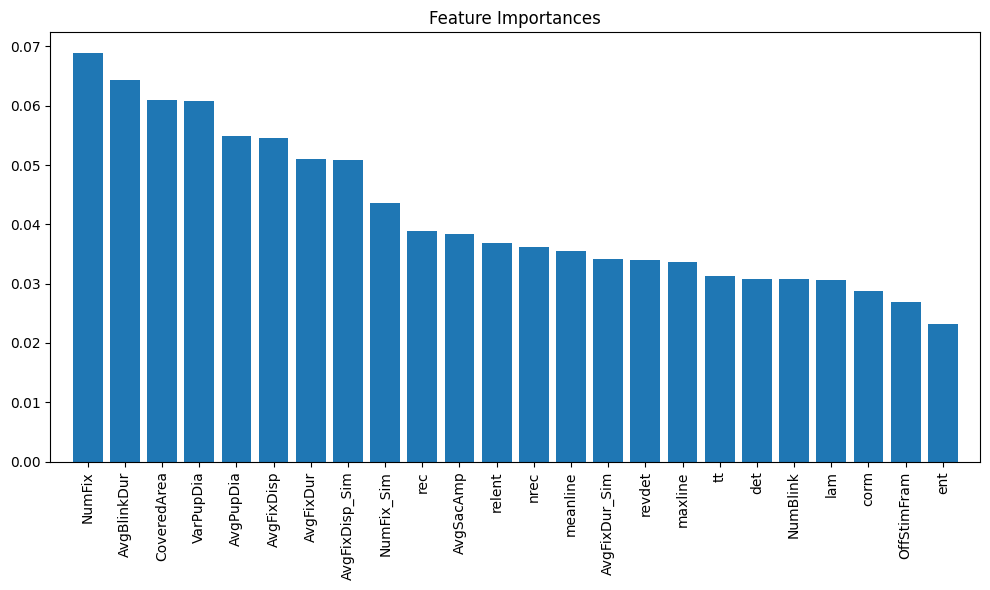

Best Hyperparameters:
clf__max_depth: None
clf__min_samples_leaf: 2
clf__min_samples_split: 10
clf__n_estimators: 200


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data for the best window size (30 sec)
window_size = 30
df = pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{window_size}sec.csv")

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]

# Prepare the data
df_filtered = df[~df['Participant'].isin(blacklist)]
X = df_filtered.drop(columns=['MW', 'Attention', 'Participant', 'Stimuli'])
y = df_filtered['Attention']
groups = df_filtered['Participant']

# Define the pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Define GroupKFold cross-validator
cv = GroupKFold(n_splits=5)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='f1')
grid_search.fit(X, y, groups=groups)

# Best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Train-test split ensuring stratification by groups
X_train, X_test, y_train, y_test, train_groups, test_groups = train_test_split(X, y, groups, test_size=0.2, stratify=groups, random_state=42)

# Train the best estimator
best_estimator.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator.predict(X_test)
y_pred_prob = best_estimator.predict_proba(X_test)[:, 1]

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Feature importance
importances = best_estimator.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Print feature importance values
print("Feature Importances:")
for feature, importance in zip(features[indices], importances[indices]):
    print(f"{feature}: {importance:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Average Accuracy: 0.667
Average F1 score: 0.714
Average Precision: 0.673
Average Recall: 0.759
Average ROC AUC: 0.720


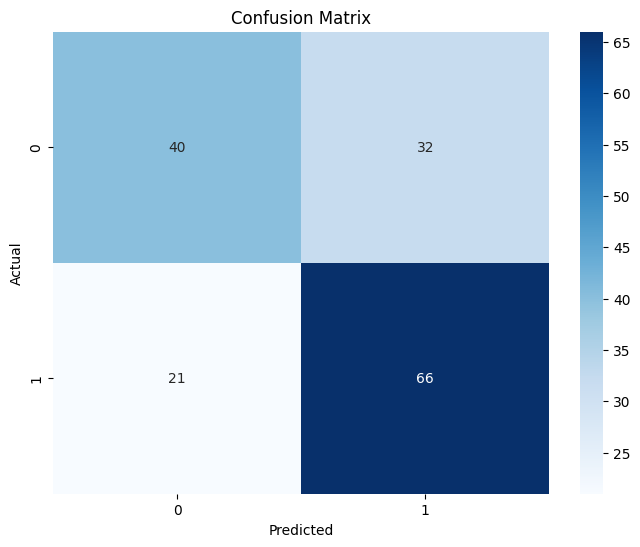

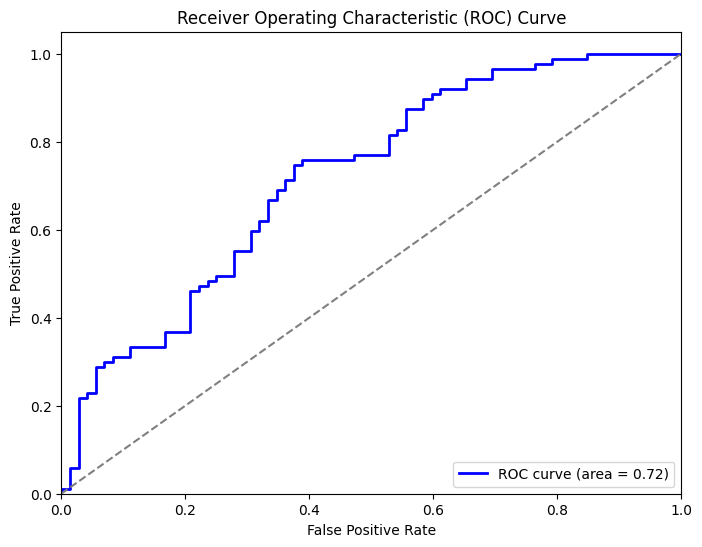

Best Hyperparameters:
clf__max_depth: None
clf__min_samples_leaf: 2
clf__min_samples_split: 10
clf__n_estimators: 200


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data for the best window size (30 sec)
window_size = 30
df = pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{window_size}sec.csv")

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]

# Prepare the data
df_filtered = df[~df['Participant'].isin(blacklist)]
X = df_filtered.drop(columns=['MW', 'Attention', 'Participant', 'Stimuli'])
y = df_filtered['Attention']
groups = df_filtered['Participant']

# Define the pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Define GroupKFold cross-validator
cv = GroupKFold(n_splits=5)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='f1')
grid_search.fit(X, y, groups=groups)

# Best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Initialize lists to store results
accuracies = []
f1_scores = []
precisions = []
recalls = []
roc_aucs = []

# Perform the process 10 times
for _ in range(10):
    # Train-test split ensuring stratification by groups
    X_train, X_test, y_train, y_test, train_groups, test_groups = train_test_split(X, y, groups, test_size=0.2, stratify=groups, random_state=42)

    # Train the best estimator
    best_estimator.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best_estimator.predict(X_test)
    y_pred_prob = best_estimator.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Append results to lists
    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    roc_aucs.append(roc_auc)

# Calculate average performance metrics
avg_accuracy = np.mean(accuracies)
avg_f1 = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_roc_auc = np.mean(roc_aucs)

# Print average performance metrics
print(f"Average Accuracy: {avg_accuracy:.3f}")
print(f"Average F1 score: {avg_f1:.3f}")
print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall: {avg_recall:.3f}")
print(f"Average ROC AUC: {avg_roc_auc:.3f}")

# Plot confusion matrix of the last iteration
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve of the last iteration
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")


## Added RQA and simplified Fixation

Average Accuracy over 10 iterations: 0.684
Average F1 Score over 10 iterations: 0.638
Feature Importances:
AvgBlinkDur: 0.0770
NumFix: 0.0728
CoveredArea: 0.0686
AvgFixDisp_Sim: 0.0602
AvgFixDisp: 0.0550
VarPupDia: 0.0540
AvgFixDur: 0.0412
AvgFixDur_Sim: 0.0397
NumFix_Sim: 0.0393
AvgPupDia: 0.0385
nrec: 0.0385
AvgSacAmp: 0.0375
rec: 0.0369
revdet: 0.0366
relent: 0.0358
corm: 0.0333
tt: 0.0329
NumBlink: 0.0324
maxline: 0.0300
det: 0.0298
meanline: 0.0295
ent: 0.0278
lam: 0.0267
OffStimFram: 0.0260


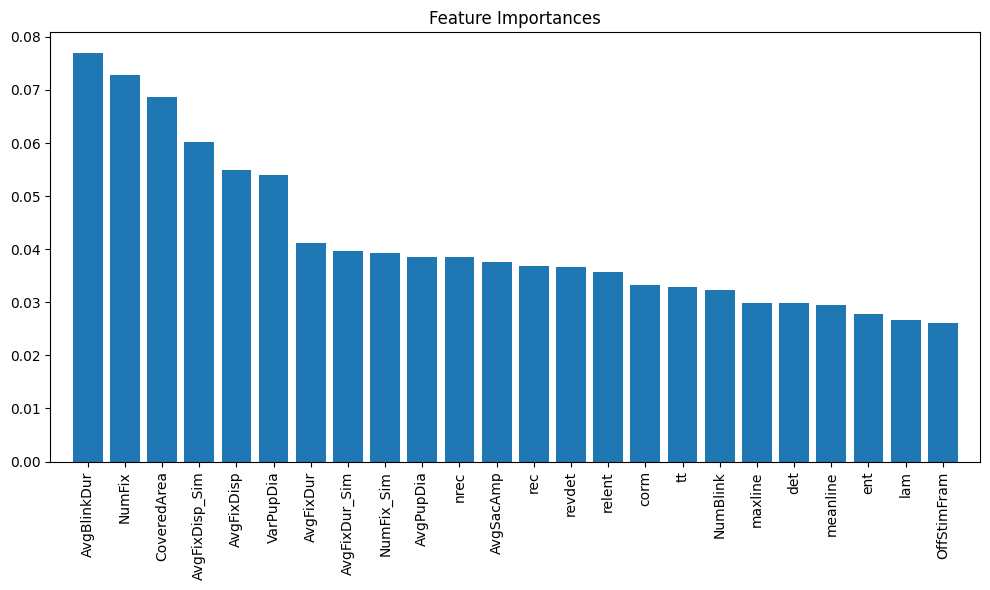

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the data for the best window size (30 sec)
window_size = 30
df = pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{window_size}sec.csv")

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]

# Prepare the data
df_filtered = df[~df['Participant'].isin(blacklist)]
X = df_filtered.drop(columns=['MW', 'Attention', 'Participant', 'Stimuli'])
y = df_filtered['MW']
groups = df_filtered['Participant']

# Define the pipeline with SimpleImputer, StandardScaler, SMOTE, and RandomForestClassifier
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        min_samples_split=10, 
        min_samples_leaf=4, 
        random_state=None))
])

# Perform the test multiple times to get average accuracy and F1 score
n_iterations = 10
accuracy_scores = []
f1_scores = []

for i in range(n_iterations):
    # Train-test split ensuring stratification by groups
    X_train, X_test, y_train, y_test, train_groups, test_groups = train_test_split(X, y, groups, test_size=0.2, stratify=groups, random_state=i)
    
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append scores
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Calculate average scores
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

# Print average scores
print(f"Average Accuracy over {n_iterations} iterations: {average_accuracy:.3f}")
print(f"Average F1 Score over {n_iterations} iterations: {average_f1:.3f}")

# Feature importance
importances = pipeline.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Print feature importance values
print("Feature Importances:")
for feature, importance in zip(features[indices], importances[indices]):
    print(f"{feature}: {importance:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


**Try different machine learning models and plot their performance for different window sizes.**

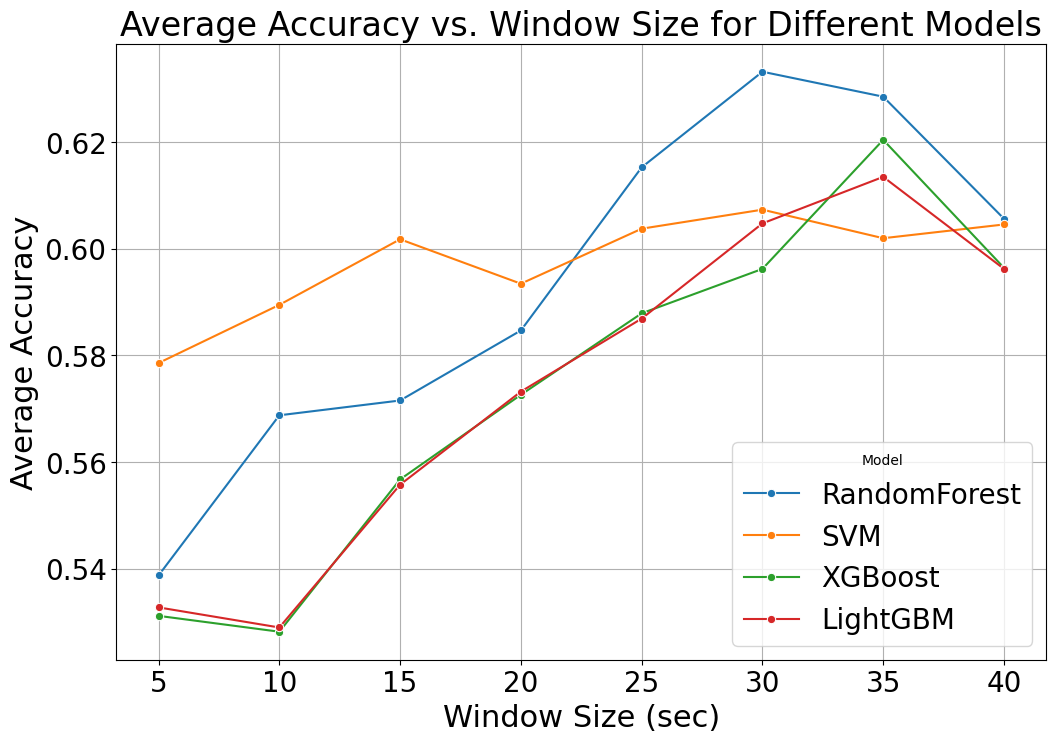

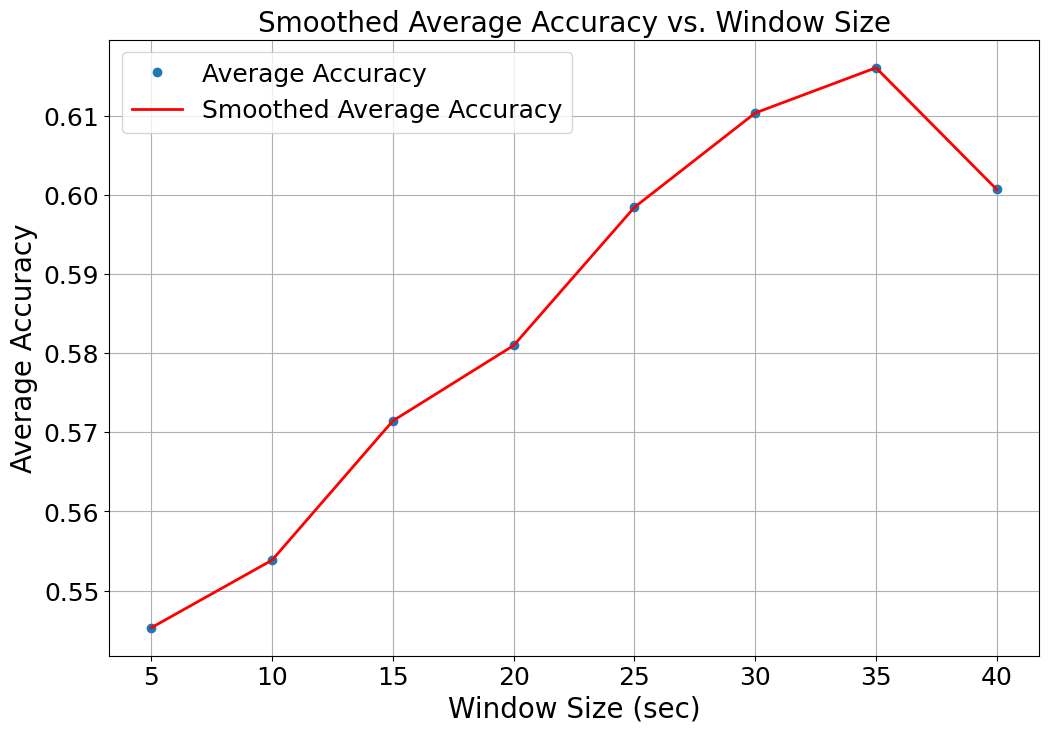

Overall Average Accuracies:
  Window size: 5 sec, Average accuracy: 0.545
  Window size: 10 sec, Average accuracy: 0.554
  Window size: 15 sec, Average accuracy: 0.571
  Window size: 20 sec, Average accuracy: 0.581
  Window size: 25 sec, Average accuracy: 0.598
  Window size: 30 sec, Average accuracy: 0.610
  Window size: 35 sec, Average accuracy: 0.616
  Window size: 40 sec, Average accuracy: 0.601
Best window size based on overall smoothed average accuracy: 35.0 sec


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load CSV files into DataFrames
window_sizes = [5 * i for i in range(1, 9)]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]

# Function to prepare data by participant, excluding blacklist
def prepare_data(df):
    df_filtered = df[~df['Participant'].isin(blacklist)]
    X = df_filtered[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp']]
    y = df_filtered['Attention']
    groups = df_filtered['Participant']
    return X, y, groups

# Number of iterations and random states
iterations = 5
random_states = range(iterations)


# Models to evaluate
models = {
    'RandomForest': RandomForestClassifier,
    'SVM': SVC,
    'XGBoost': XGBClassifier,
    'LightGBM': lambda random_state: LGBMClassifier(random_state=random_state, verbose=-1)  # Suppress LightGBM warnings
}

# Loop through each DataFrame, model, and random state
results = {w: {model: [] for model in models} for w in window_sizes}
for w, df in zip(window_sizes, dataframes):
    X, y, groups = prepare_data(df)
    gkf = GroupKFold(n_splits=5)
    
    for model_name, model in models.items():
        for random_state in random_states:
            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('classifier', model(random_state=random_state) if model_name not in ['SVM'] else model())
            ])
            accuracy_scores = cross_val_score(pipeline, X, y, groups=groups, cv=gkf, scoring=make_scorer(accuracy_score))
            results[w][model_name].extend(accuracy_scores)

# Calculate average accuracy for each model and window size
average_results = {w: {model: np.mean(scores) for model, scores in models_scores.items()} for w, models_scores in results.items()}

# Convert average_results to a DataFrame for plotting
average_results_df = pd.DataFrame.from_dict(average_results, orient='index').reset_index().melt(id_vars='index')
average_results_df.columns = ['window_size', 'model', 'average_accuracy']

# Plot accuracy changes for all models
plt.figure(figsize=(12, 8))
sns.lineplot(x='window_size', y='average_accuracy', hue='model', data=average_results_df, marker='o')

# Adjust font sizes
plt.xlabel('Window Size (sec)', fontsize=22)
plt.ylabel('Average Accuracy', fontsize=22)
plt.title('Average Accuracy vs. Window Size for Different Models', fontsize=24)
plt.legend(title='Model', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Calculate overall average accuracy for each window size
overall_average_accuracy = {w: np.mean(list(models_scores.values())) for w, models_scores in average_results.items()}

# Convert overall_average_accuracy to a DataFrame for smoothing and plotting
overall_average_df = pd.DataFrame(list(overall_average_accuracy.items()), columns=['window_size', 'average_accuracy'])

# Smooth the curve using LOWESS
smoothed = lowess(overall_average_df['average_accuracy'], overall_average_df['window_size'], frac=0.3)

# Plot the smoothed curve of overall average accuracy
plt.figure(figsize=(12, 8))
plt.plot(overall_average_df['window_size'], overall_average_df['average_accuracy'], 'o', label='Average Accuracy')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='Smoothed Average Accuracy', linewidth=2)

# Adjust font sizes
plt.xlabel('Window Size (sec)', fontsize=20)
plt.ylabel('Average Accuracy', fontsize=20)
plt.title('Smoothed Average Accuracy vs. Window Size', fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Print overall average accuracies
print("Overall Average Accuracies:")
for w, avg_accuracy in overall_average_accuracy.items():
    print(f"  Window size: {w} sec, Average accuracy: {avg_accuracy:.3f}")

# Find the best window size based on smoothed curve
best_window_size = smoothed[np.argmax(smoothed[:, 1]), 0]
print(f"Best window size based on overall smoothed average accuracy: {best_window_size:.1f} sec")


## 3. Feature Importance

### 3.1 Check for Multicollinearity Using the Variance Inflation Factor (VIF)

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')

# Remove blacklisted participants
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]

# Define predictor variables
predictors = ['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 
              'OffStimFram', 'AvgSacAmp', 'AvgFixDisp']

# Drop rows with missing values
df_cleaned = df.dropna(subset=predictors + ['MW'])

# Normalize the predictor variables
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df_cleaned[predictors])
X_normalized = pd.DataFrame(X_normalized, columns=predictors, index=df_cleaned.index)

# Define the target variable
y = df_cleaned['MW']

# Calculate initial VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_normalized.columns
vif_data["VIF"] = [variance_inflation_factor(X_normalized.values, i) for i in range(len(vif_data["feature"]))]
print("Initial VIF Data:\n", vif_data)


Initial VIF Data:
        feature       VIF
0       NumFix  3.012451
1    AvgFixDur  2.399285
2     NumBlink  1.908906
3  AvgBlinkDur  2.381924
4    AvgPupDia  1.310714
5    VarPupDia  1.375666
6  OffStimFram  1.493487
7    AvgSacAmp  1.311110
8   AvgFixDisp  1.487186


High VIF Values: VIF values greater than 10 indicate problematic levels of multicollinearity. 

The variables AvgFixDur, LastFixDur, and LastFixDurDiff far exceed this, suggesting that they are likely redundant given the other variables in the model.

We should remove those variables first and fit the logistic regression model.

In [12]:
# Drop variables with high VIF values to address multicollinearity
high_vif_cols = []
X_normalized_reduced = X_normalized.drop(columns=high_vif_cols)

# Add a constant to the model (intercept)
X_normalized_reduced = sm.add_constant(X_normalized_reduced)

# Fit a logistic regression model
logit_model_reduced = sm.Logit(y, X_normalized_reduced).fit()

# Display the summary of the reduced logistic regression model
print(logit_model_reduced.summary())

Optimization terminated successfully.
         Current function value: 0.622885
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     MW   No. Observations:                  792
Model:                          Logit   Df Residuals:                      782
Method:                           MLE   Df Model:                            9
Date:                Sun, 26 May 2024   Pseudo R-squ.:                 0.09435
Time:                        15:11:57   Log-Likelihood:                -493.33
converged:                       True   LL-Null:                       -544.72
Covariance Type:            nonrobust   LLR p-value:                 4.287e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2025      0.077     -2.636      0.008      -0.353      -0.052
NumFix         -0.5835    

**Summary of Logistic Regression Results:**
-   Likelihood Ratio Test p-value: 4.162e-19, indicating the model is statistically significant.
-   NumFix: 0.0424 (p < 0.001) - A significant positive relationship with attention, indicating more fixations are associated with focused attention.
-   AvgFixDisp: 5.8606 (p = 0.006) - A significant positive relationship, suggesting that higher average fixation dispersion is associated with focused attention.

### 3.2 Correlation Heatmap of extracted features

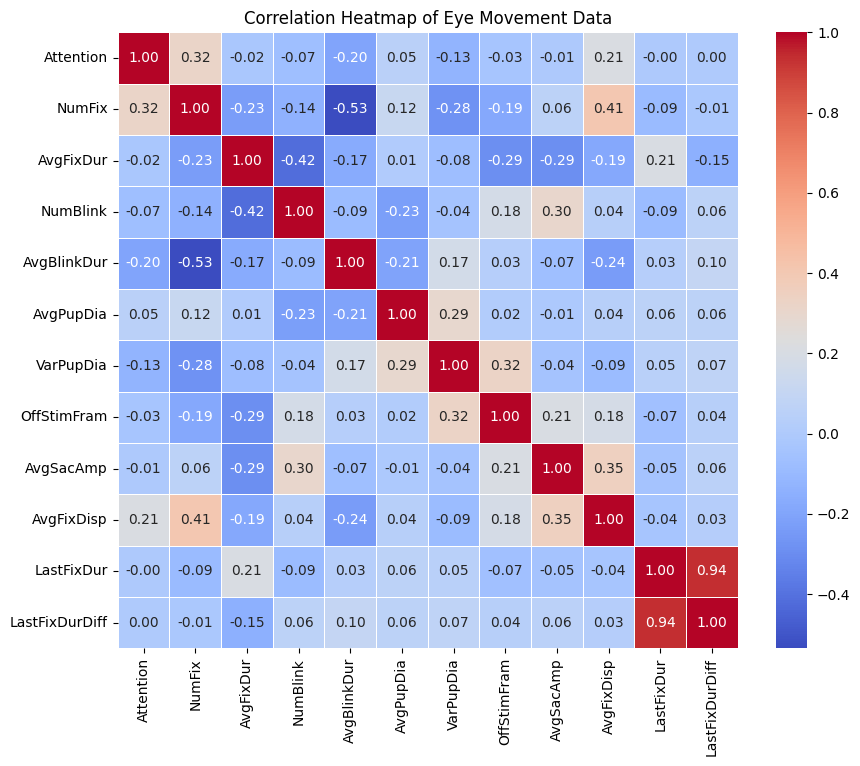

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]
X = df[['Attention', 'NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Eye Movement Data")
plt.show()

### 3.3 Between-group variation and Within-group variation
一人ずつ固定します、彼らのFocus時とMW時のNumFixとAvgFixDispの平均を求めます。そうすると33個のデータを得ることができます。

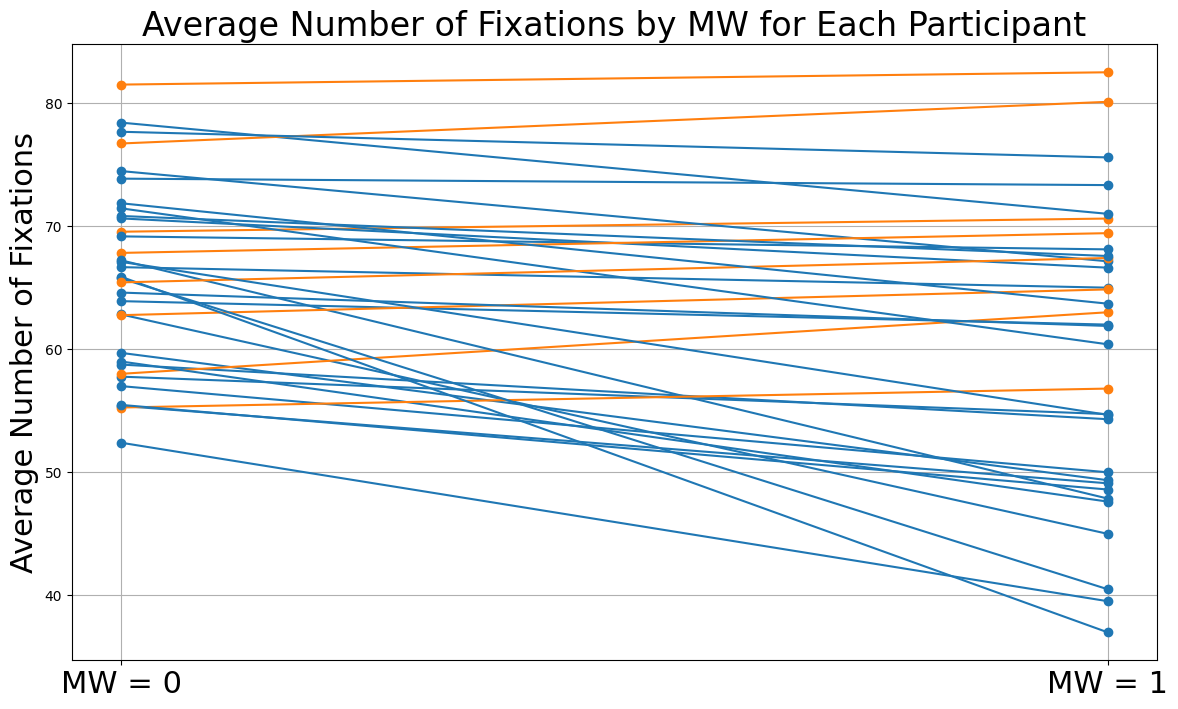

Participants with inclined lines: ['13S', '18N', '20T', '2U', '30Y', '33K', '34I', '5N']
Number of participants with inclined lines: 8
Number of participants with declined lines: 25


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# データをロード
file_path = '../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv'
df = pd.read_csv(file_path)
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]

# ParticipantとAttentionでグループ化し、平均NumFixを計算
avg_numfix = df.groupby(['Participant', 'MW'])['NumFix'].mean().unstack()

avg_numfix.reset_index(inplace=True)

# プロット
fig, ax = plt.subplots(figsize=(14, 8))
inclined_participants = []  # 傾斜のあるParticipantのリスト
for _, row in avg_numfix.iterrows():
    if row[1] > row[0]:
        color = 'C1'  # デフォルトの2番目の色（通常はオレンジ）
        inclined_participants.append(row['Participant'])
    else:
        color = 'C0'  # デフォルトの1番目の色（通常は青）
    ax.plot([0, 1], [row[0], row[1]], marker='o', linestyle='-', color=color)

ax.set_xticks([0, 1])
ax.set_xticklabels(['MW = 0', 'MW = 1'], fontsize=22)
ax.set_ylabel('Average Number of Fixations', fontsize=22)
ax.set_title('Average Number of Fixations by MW for Each Participant', fontsize=24)

# 傾向の分析（Attention 1 > Attention 0の場合はinclined、それ以外はdeclined）
trends = (avg_numfix[1] > avg_numfix[0]).value_counts()

# 傾向数を表示
inclined = trends.get(True, 0)
declined = trends.get(False, 0)

plt.grid(True)
plt.show()

print(f"Participants with inclined lines: {inclined_participants}")
print(f"Number of participants with inclined lines: {inclined}")
print(f"Number of participants with declined lines: {declined}")


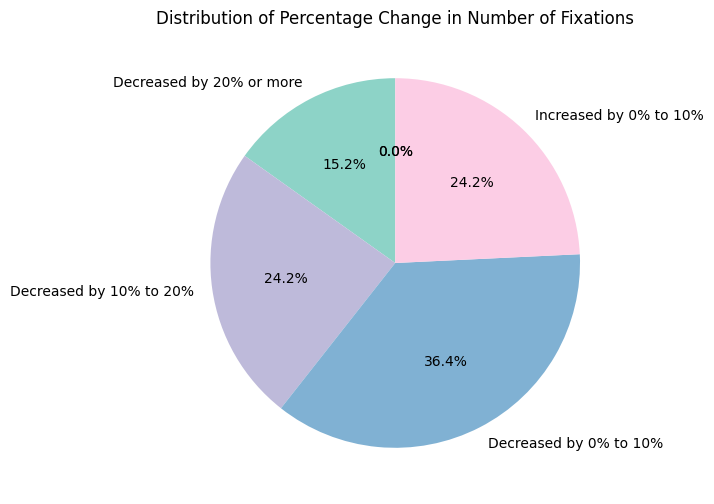

Participants with an increase of 20% or more in the number of fixations:
[]


In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming avg_numfix is your DataFrame with columns [0] for Attention=0 and [1] for Attention=1 already calculated
percentage_changes = ((avg_numfix[1] - avg_numfix[0]) / avg_numfix[0]) * 100

# Define bins for the categories
bins = [-float('inf'), -20, -10, 0, 10, 20, float('inf')]
labels = [
    'Decreased by 20% or more',
    'Decreased by 10% to 20%',
    'Decreased by 0% to 10%',
    'Increased by 0% to 10%',
    'Increased by 10% to 20%',
    'Increased by 20% or more'
]

# Categorize the percentage changes
categories = pd.cut(percentage_changes, bins, labels=labels, include_lowest=True, ordered=True)

# Count the number of participants in each bin
category_counts = categories.value_counts(sort=False)
category_counts_normalized = category_counts / category_counts.sum()

# Plotting
plt.figure(figsize=(10, 6))
category_counts_normalized.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap="Set3", labels=labels)
plt.ylabel('')  # Remove the y-label as it is unnecessary for pie charts
plt.title('Distribution of Percentage Change in Number of Fixations')
plt.show()

# Identify participants with an increase of 20% or more
increased_20_or_more = percentage_changes[percentage_changes > 20]
participants_increased_20_or_more = increased_20_or_more.index.tolist()

print("Participants with an increase of 20% or more in the number of fixations:")
print(participants_increased_20_or_more)

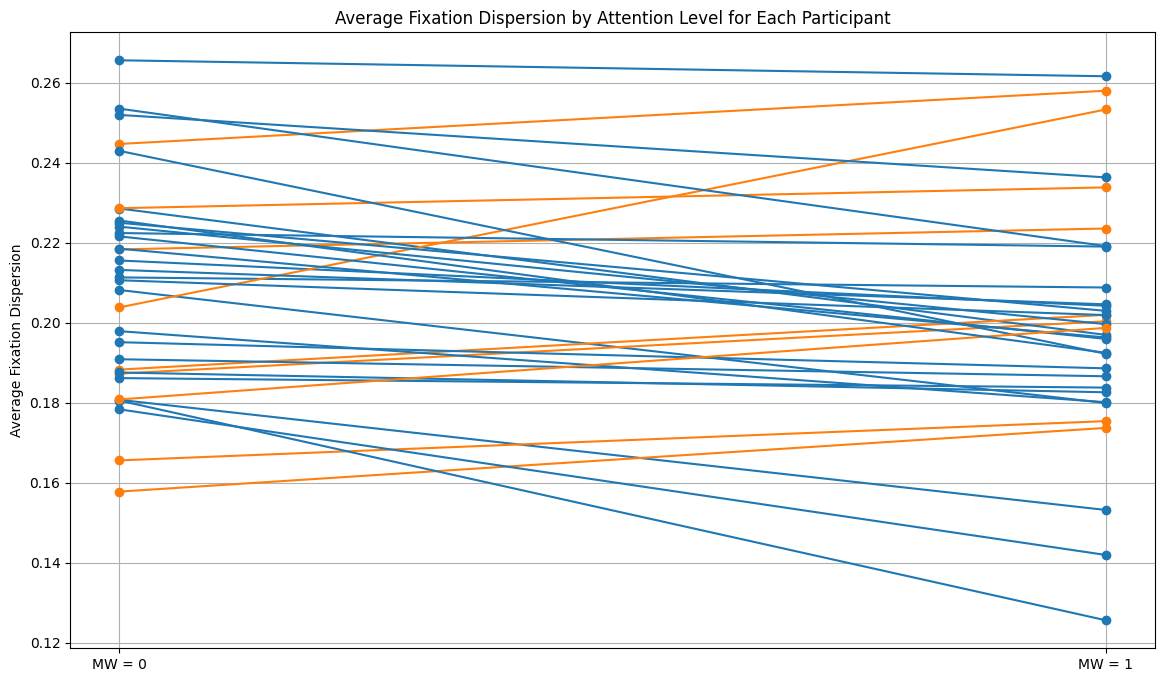

Participants with inclined lines: ['12K', '13S', '14T', '16Y', '18N', '19M', '20T', '27I', '5N']
Number of participants with inclined lines: 9
Number of participants with declined lines: 24


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# データをロード
file_path = '../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv'
df = pd.read_csv(file_path)
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]

# ParticipantとAttentionでグループ化し、平均AvgFixDispを計算
avg_fixdisp = df.groupby(['Participant', 'MW'])['AvgFixDisp'].mean().unstack()

avg_fixdisp.reset_index(inplace=True)

# プロット
fig, ax = plt.subplots(figsize=(14, 8))
inclined_participants = []  # 傾斜のあるParticipantのリスト
for _, row in avg_fixdisp.iterrows():
    if row[1] > row[0]:
        color = 'C1'  # デフォルトの2番目の色（通常はオレンジ）
        inclined_participants.append(row['Participant'])
    else:
        color = 'C0'  # デフォルトの1番目の色（通常は青）
    ax.plot([0, 1], [row[0], row[1]], marker='o', linestyle='-', color=color)

ax.set_xticks([0, 1])
ax.set_xticklabels(['MW = 0', 'MW = 1'])
ax.set_ylabel('Average Fixation Dispersion')
ax.set_title('Average Fixation Dispersion by Attention Level for Each Participant')

# 傾向の分析（Attention 1 > Attention 0の場合はinclined、それ以外はdeclined）
trends = (avg_fixdisp[1] > avg_fixdisp[0]).value_counts()

# 傾向数を表示
inclined = trends.get(True, 0)
declined = trends.get(False, 0)

plt.grid(True)
plt.show()

print(f"Participants with inclined lines: {inclined_participants}")
print(f"Number of participants with inclined lines: {inclined}")
print(f"Number of participants with declined lines: {declined}")


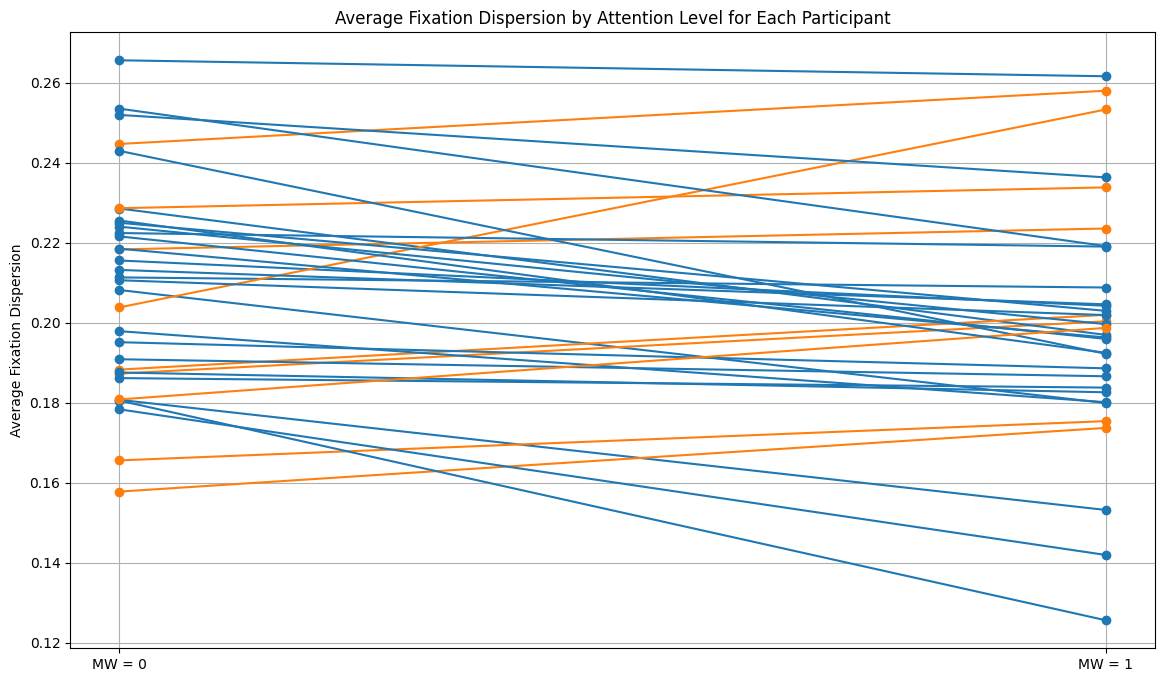

Participants with more than 20% decline: ['26K', '31M', '40K']


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# データをロード
file_path = '../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv'
df = pd.read_csv(file_path)
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]

# ParticipantとAttentionでグループ化し、平均AvgFixDispを計算
avg_fixdisp = df.groupby(['Participant', 'MW'])['AvgFixDisp'].mean().unstack()
avg_fixdisp.reset_index(inplace=True)

# 20％以上の減少を示す参加者を特定
declined_participants = avg_fixdisp[(avg_fixdisp[0] - avg_fixdisp[1]) / avg_fixdisp[0] > 0.2]['Participant'].tolist()

# プロット
fig, ax = plt.subplots(figsize=(14, 8))
for _, row in avg_fixdisp.iterrows():
    if row[1] > row[0]:
        color = 'C1'  # デフォルトの2番目の色（通常はオレンジ）
    else:
        color = 'C0'  # デフォルトの1番目の色（通常は青）
    ax.plot([0, 1], [row[0], row[1]], marker='o', linestyle='-', color=color)

ax.set_xticks([0, 1])
ax.set_xticklabels(['MW = 0', 'MW = 1'])
ax.set_ylabel('Average Fixation Dispersion')
ax.set_title('Average Fixation Dispersion by Attention Level for Each Participant')

# グリッド表示
plt.grid(True)
plt.show()

# 20％以上の減少を示す参加者を表示
print("Participants with more than 20% decline:", declined_participants)


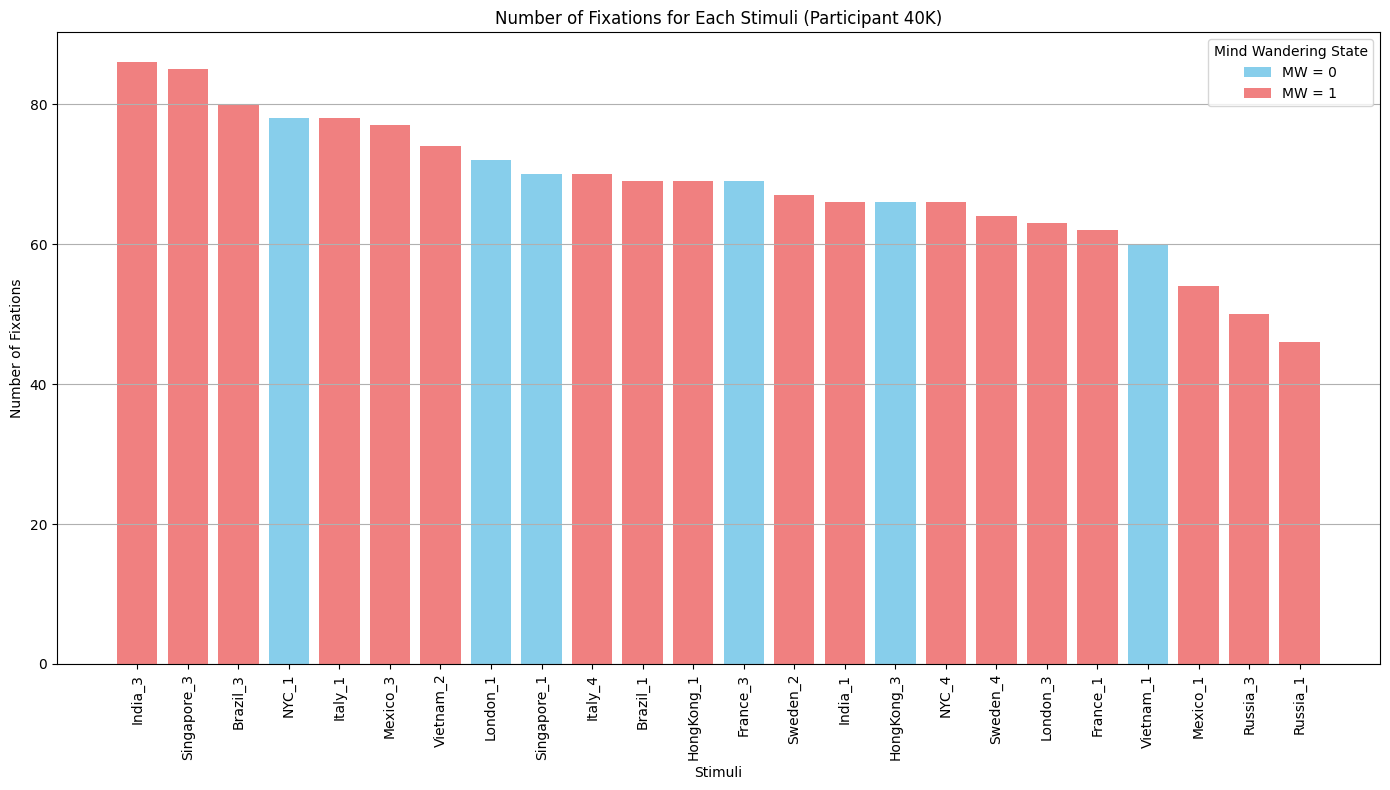

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# データをロード
file_path = '../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv'
df = pd.read_csv(file_path)
blacklist = ["22K", "25I", "29N", "39Y", "8I", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]

# 参加者 '40K' のデータをフィルタリング
participant_data = df[df['Participant'] == '1Y']

# 各刺激に対する固定回数を計算
fixation_counts = participant_data.groupby(['Stimuli', 'MW'])['NumFix'].sum().reset_index()

# MWの状態に基づいて色を設定
fixation_counts['Color'] = fixation_counts['MW'].map({0: 'skyblue', 1: 'lightcoral'})

# 固定回数の降順に並べ替え
fixation_counts.sort_values(by='NumFix', ascending=False, inplace=True)

# 棒グラフをプロット
plt.figure(figsize=(14, 8))
bars = plt.bar(fixation_counts['Stimuli'], fixation_counts['NumFix'], color=fixation_counts['Color'])

# 凡例の追加
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='MW = 0'),
                   Patch(facecolor='lightcoral', label='MW = 1')]
plt.legend(handles=legend_elements, title="Mind Wandering State")

plt.xlabel('Stimuli')
plt.ylabel('Number of Fixations')
plt.title('Number of Fixations for Each Stimuli (Participant 40K)')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.tight_layout()
plt.show()
